In [1]:
import statsmodels.api as sm
from scipy import interpolate
from pandas import Series, DataFrame, Panel
from string import ascii_lowercase as letters
from scipy.stats import chisqprob
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import random
import math
from scipy.stats import wrapcauchy
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
plt.style.use('classic')
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
np.random.seed(1234)

/srv/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def rw2(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
    return(x,y)   
    
n=1000 #sample size
alpha=2 #scale
beta=5 #shape
c=0.9# shape parameter for Wrapped Cauchy distribution, it needs to be between 0 and 1
data = rw2(n)
x=data[0]
y=data[1]
t=range(0,n)

In [3]:
# average distance
def rw2_distance(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    distance=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
        distance[i]=(x[i]**2+y[i]**2)**0.5
    return distance 
    
n=1000 #sample size
alpha=2 #scale
beta=5 #shape
c=0.9# shape parameter for Wrapped Cauchy distribution, it needs to be between 0 and 1
data_distance = rw2_distance(n)
t=range(0,n)
#data_distance

In [4]:
number_of_simulations=300# this is the number of rows or row vectors
average_distances=np.zeros((number_of_simulations,n))
for i in range(number_of_simulations):
    average_distances[i]=rw2_distance(n)


In [5]:
matrix=np.zeros((2,5))# 2 rows 5 columns
matrix[1]=range(0,5)
matrix[0]=range(5,10)
print(matrix)
print(matrix.mean(axis=0))

[[ 5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.]]
[ 2.5  3.5  4.5  5.5  6.5]


In [6]:
# the mean average distance after 1 step, 2 steps, etc...

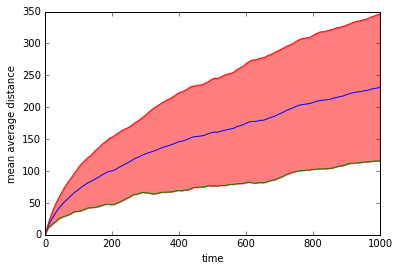

In [7]:
u=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
plt.plot(t,u)
plt.fill_between(t, u-error, u+error,color='red',alpha=0.5)
plt.plot(t,u-error)
plt.plot(t,u+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

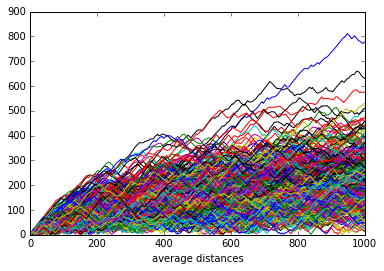

In [8]:
plt.plot(average_distances.T)
plt.xlabel('time')
plt.xlabel('average distances')
plt.show()

In [9]:
#not fine since D is supposed to be a number
 #the mean diffusion coefficient for the original data
#mean_D_original=np.zeros(len(t))  # skip zeros
#for i in range(len(mean_D_original)):
 #   mean_D_original[i]=(y[i]**2)/(2*t[i])
#mean_D_original=mean_D_original[1:] #get rid of the nan because vectors start from zero 
#mean_D_original_coefficient=np.mean(mean_D_original[600:])
#mean_D_original_coefficient

In [10]:
D=u**2/(2*np.array(t))
D_coeff=np.mean(D[800:])
D_coeff

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


26.7802

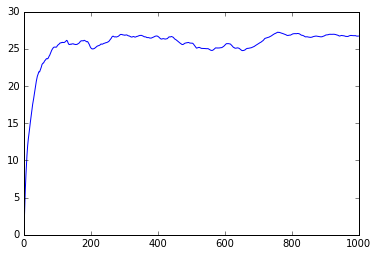

In [14]:
plt.plot(D)

In [15]:
# Now put them into the MCMC sampler, the second model is to be considered
import scipy.stats 
from scipy.stats import dweibull
def log_likelihood(x,a,b):# a is shape, b is scale
     return sum(dweibull.logpdf(x,scale=b,c=a))
def log_wclikelihood(x,a,b):
     return sum(wrapcauchy.logpdf(x,c=a,loc=b))# c is the shape parameter

In [16]:
#time_step=1
# my code pretty much starts here
time_step=1
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [17]:
x_new=f(t_new)
y_new=g(t_new)

In [18]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

998
998
998
997
997


In [19]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.03 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3451


0.905057291105
0.905048040942
18980


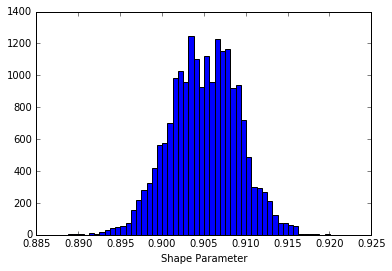

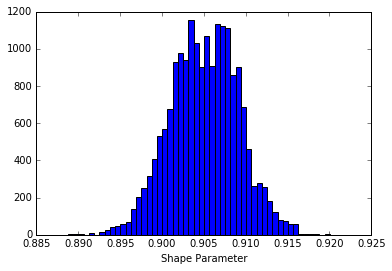

In [20]:
print(np.mean(A1))
print(np.mean(A1[1000:]))# burn in 1000
plt.hist(A1,bins=50)
B1=np.array(A1[1000:])
print(len(B1))
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()

In [21]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.08,0.08]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3463


20001
5.07370326854
2.00875749348


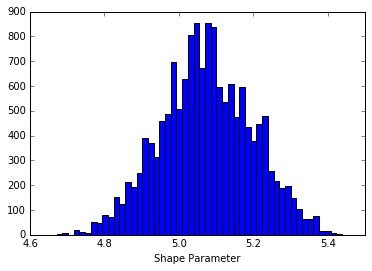

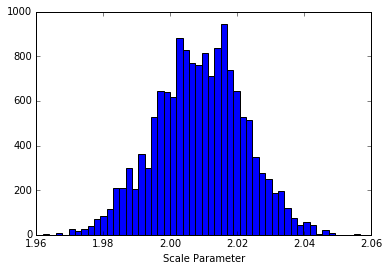

In [22]:
print(len(A2))
B2=np.array(A2)[5000:]#burn-in 1000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)# now changing the parameters and n with the ones that I got
plt.xlabel("Scale Parameter")
plt.show()# now changing the parameters and n with the ones that I got


In [23]:
# I need the mean diffusion coefficient for the data generated by the parameters obtained from inference

In [34]:
# Weibull
shape_parameters=B2[:,0]
scale_parameters=B2[:,1]
# select every 10th observation
shape_parameters_need=shape_parameters[::10][:-1301]# same length now
scale_parameters_need=scale_parameters[::10][:-1301]
#Wrapped Cauchy
shapewc_parameters=B1
shapewc_parameters_need=B1[::10][:-1698]
print(len(shapewc_parameters_need))
print(len(scale_parameters_need))
print(len(shape_parameters_need))

200
200
200


In [35]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change,alpha_change,beta_change,c_change):# this gives samples from the inference model
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=np.zeros(n_change)
    distance_origin=np.zeros(n_change)
    distance=np.zeros(n_change)
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance_origin[i]=(x_change[i]**2+y_change[i]**2)**0.5
        distance[i]=r
    return [x_change,y_change,distance,theta,distance_origin]   
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_parameters_need#int(input("what's the scale?"))
beta_change=shape_parameters_need #int(input("what's the shape?"))
c_change=shapewc_parameters_need# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1
#x_change = np.array(rw2_change(n_change)[0])
#y_change=np.array(rw2_change(n_change)[1])
#data_change=np.array(rw2_change(n_change)[2])
#theta_change=np.array(rw2_change(n_change)[3])
#the previous code

In [36]:
#print(scale_parameters_need)
#print(shape_parameters_need)
#print(shapewc_parameters_need)
print(n_change)


997


In [37]:
print(len(shapewc_parameters_need))
print(len(scale_parameters_need))
print(len(shape_parameters_need))
#make them the same size, check again

200
200
200


In [38]:
length_datas=1000

In [39]:
data_change=np.zeros((len(shape_parameters_need),length_datas))
theta_change=np.zeros((len(shapewc_parameters_need),length_datas))
# do arrays, matrices

In [40]:
print(len(alpha_change))
print(len(shape_parameters_need))
print(length_datas)
print(len(beta_change))
print(len(c_change))
hello=np.array(rw2_change(length_datas,alpha_change[1],beta_change[1],c_change[1])[2])
print(len(np.array(rw2_change(length_datas,alpha_change[1],beta_change[1],c_change[1])[2])))
print(len(np.array(rw2_change(length_datas,alpha_change[1],beta_change[1],c_change[1])[4])))
# works now

200
200
1000
200
200
1000
1000


In [41]:
count=0
for i in range(len(hello)-1):
    if hello[i]==0:
        count+=1
count        
# works now

1

In [42]:
#if you want to make them the same size
print(len(theta_change))
#print(len(theta_original))
#print(len(r_original))
print(len(data_change))
#Let's go to 999 then
#theta_change=theta_change[:999]
#theta_original=theta_original[:999]
#data_change=data_change[:999]
#shape_parameters_need=shape_parameters_need[:999]
#scale_parameters_need=scale_parameters_need[:999]
#shapewc_parameters_need=shapewc_parameters_need[:999]

200
200


In [43]:
# mistake here should be without -1
for i in range(len(shape_parameters_need)):
                     data_change[i,]=np.array(rw2_change(length_datas,alpha_change[i],beta_change[i],c_change[i])[2])#the distances

In [44]:
for i in range(len(shape_parameters_need)):
                     theta_change[i,]=np.array(rw2_change(length_datas,alpha_change[i],beta_change[i],c_change[i])[3])#the angles

In [45]:
#theta_change[1299] again zeros
#data_change[1299] zeros again

In [46]:
up=5
check=np.zeros(5)
length=len(check)
for i in range(0,length):
    check[i]=i+1
check    
# it's a mistake in here , should be len-1

array([ 1.,  2.,  3.,  4.,  5.])

In [47]:
# the mean of the inferred parameters
mean_shape_weibullparameter=np.mean(shape_parameters)
mean_scale_weibullparameter=np.mean(scale_parameters)
mean_shape_wcparameter=np.mean(shapewc_parameters)

In [48]:
# I need to find out the average D from 1000 simulations for all the data that I've generated
# this is for 1 data, you need to do it for at least 200
# I need to create a matrix or a list to store my results
number_of_simulations=300
average_distances_change=np.zeros((number_of_simulations,length_datas))
y_change=np.zeros((len(shape_parameters_need),length_datas))
for i in range(len(shape_parameters_need)):
    for j in range(number_of_simulations):
        average_distances_change[j]=rw2_change(length_datas,alpha_change[i],beta_change[i],c_change[i])[4]
    y_change[i]=average_distances_change.mean(axis=0)
# for every set of parameters you run 100 times
# y_change is a matrix that stores on each row the <d> vectors for y_replicate

In [49]:
#test the code

In [50]:
# calculating the D's the diffusion coefficients
mean_D_replicate=np.zeros((len(shape_parameters_need),length_datas))
mean_D_replicate_coefficient=np.zeros(len(shape_parameters_need))
for i in range(len(shape_parameters_need)):
    mean_D_replicate[i]=(y_change[i]**2)/(2*np.array(t))# should be the same here since interpolation doesn't do anything
    mean_D_replicate_coefficient[i]=np.mean(mean_D_replicate[i][800:])
# key question here about time
 # the first 1000  
 # I think I need to change a bit, since I divide by smaller numbers, so I will change the code up and have less

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


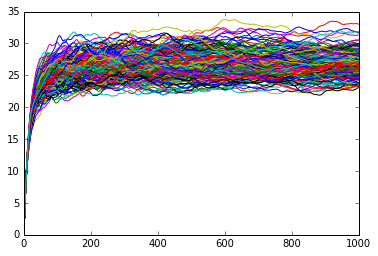

In [51]:
plt.plot(mean_D_replicate.T)
plt.show()

In [53]:
# compare the test statistics
T_y=D_coeff# this a vector 
T_y_rep=mean_D_replicate_coefficient#[1:]


In [54]:
T_y

26.7802

In [55]:
T_y_rep

array([ 26.5924,  29.1478,  26.0901,  28.6057,  27.443 ,  27.8862,
        26.5499,  29.4879,  27.1406,  26.1515,  27.3025,  26.6678,
        26.6735,  29.365 ,  27.6389,  29.9451,  24.2754,  27.8355,
        26.124 ,  26.1624,  28.0541,  25.9921,  26.4075,  23.535 ,
        27.6668,  23.3066,  26.4423,  25.3249,  24.992 ,  26.5274,
        32.6163,  26.9838,  24.5516,  31.429 ,  25.8887,  26.7675,
        26.366 ,  27.057 ,  27.9295,  28.602 ,  22.65  ,  25.0344,
        28.4548,  25.7238,  24.7613,  27.2227,  29.2712,  23.9447,
        26.5573,  29.0109,  29.1068,  28.0097,  26.8778,  26.2412,
        27.7413,  26.6225,  28.9075,  25.6582,  22.8693,  24.035 ,
        26.4928,  24.8665,  28.1446,  24.8406,  25.4646,  25.821 ,
        25.8188,  28.1123,  29.055 ,  25.7338,  28.5665,  27.0225,
        26.2631,  27.4582,  28.8771,  29.4332,  26.9926,  26.6791,
        23.7087,  24.654 ,  27.5222,  29.2002,  28.8809,  25.5741,
        29.1035,  25.2822,  25.3662,  28.0101,  26.2295,  27.0

In [56]:
len(T_y_rep)

200

In [57]:
count=0
for i in range(len(shape_parameters_need)):
    if T_y_rep[i]>T_y:
        count+=1
print(count)
print(len(shape_parameters_need))
ppp_value=count/len(shape_parameters_need)
print(ppp_value)

98
200
0.49


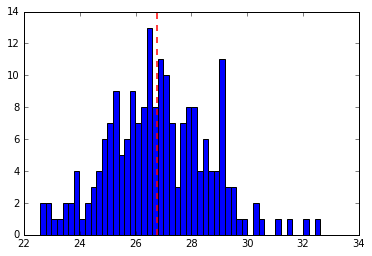

In [58]:
plt.hist(T_y_rep,bins=50)
plt.axvline(T_y,linestyle='dashed', linewidth=1.5,color='red')
plt.show()
